CPH 08/2022

# MOCCA Tutorial

MOCCA is a tool for the analysis of *High-Performance Liquid Chromatography–Diode Array Detection* (HPLC–DAD) datasets which are recorded in the context of reaction (process) controls. It only uses HPLC–DAD raw data and some basic user input which will be explained in this tutorial. For now, the program is only accessible to users with some basic Python skills and a Python environment up and running.

## Installation and documentation

For information on the installation, please visit MOCCA's GitHub repository (https://github.com/HaasCP/mocca) and documentation (https://mocca.readthedocs.io/en/latest/readme.html) as well as the corresponding scientific publication (https://doi.org/10.26434/chemrxiv-2022-0pv2d, this content is a preprint and has not been peer-reviewed).

## Imports

In [43]:
!pip install --upgrade pip

In [44]:
!pip install -e ..

Obtaining file:///Users/bensonlee/dev/mocca
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mocca (pyproject.toml) ... done
  Created wheel for mocca: filename=mocca-0.1.3-0.editable-py3-none-any.whl size=4435 sha256=c62648f12c80aad4bf7bccc8fed38d2791eecc6ba8b45e6f96f7c61ed31f2f22
  Stored in directory: /private/var/folders/nh/_fhbzrp900sgf42hrjz880j40000gn/T/pip-ephem-wheel-cache-kqxmzdd8/wheels/f3/c7/b2/d371b009031d10b52cb898b5666b49cf019dbbb343f3a36f5d
Successfully built mocca
  Attempting uninstall: mocca
    Found existing installation: mocca 0.0.post1.dev195+g6db1627.d20231107
    Uninstalling mocca-0.0.post1.dev195+g6db1627.d20231107:
      Successfully uninstalled mocca-0.0.post1.dev195+g6db1627.d20231107


In [13]:
!pip install datapane

In [14]:
import mocca.user_interaction.campaign
import mocca.report.main

In [40]:
mocca.__version__

'0.0.post1.dev195+g6db1627.d20231107'

In [15]:
dir(mocca.user_interaction.campaign)

['HplcDadCampaign',
 'PeakDatabase',
 'QualiComponentDatabase',
 'QuantComponentDatabase',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'dill',
 'logging',
 'process_compound_experiments',
 'process_experiments',
 'process_gradients']

In [16]:
# folders handling
import os
from glob import glob

# user interaction
from mocca.user_interaction.campaign import HplcDadCampaign
from mocca.user_interaction.user_objects import Gradient
from mocca.user_interaction.user_objects import Compound
from mocca.user_interaction.user_objects import InternalStandard
from mocca.user_interaction.user_objects import HplcInput
from mocca.user_interaction.settings import Settings
from mocca.report.main import report

%load_ext autoreload
%autoreload 2

## Test data folder handling

Some test data are added to the package in order to make this tutorial interactive. The test data can be found in the package in the folder mocca -> notebooks -> test_data. The data was recorded on an Agilent system (file extension .D).

In [17]:
# get path of this notebook
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

# add the path to the test data folder
test_data_path = os.path.join(ipynb_path, "tutorial_data")

# find all folders containing Agilent HPLC data (.D file extension)
folders = glob(test_data_path + '/*' + '.D') 
folders = sorted(folders)

We added four paths to the folders variable, which are two gradients (more detail why **two** gradients [below](#gradient_handling)) and two samples containing the same analyte (second only half the concentration). In the following, we want to use the first analyte run to "train" the tool and to subsequently analyze the second run.

In [18]:
for folder in folders:
    print(os.path.basename(folder))

2022-01-26_19-37-57_gradient.D
2022-01-26_19-43-27_gradient.D
2022-01-26_19-48-52_ba_1.D
2022-01-26_20-00-51_ba_0.5.D


## Basic user interaction

The tool uses multiple HPLC–DAD datasets for contextual analysis. These datasets are stored and processed in so called HPLC–DAD campaigns, which later on also contain results of the analysis. You can initialize HplcDadCampaign objects as follows:

In [19]:
camp = HplcDadCampaign()

You can add HPLC–DAD chromatograms to the campaign using HplcInput objects. For any HplcInput object, at least a path to the actual data has to be given as well as a corresponding gradient run.

### Gradient handling <a id='gradient_handling'></a>

Instead of a baseline correction routine for each individual HPLC–DAD chromatogram, MOCCA requires the data of a pre-recorded gradient run which is baseline-corrected and subsequently subtracted from the following HPLC–DAD chromatogram. A Gradient object in MOCCA only requires the path to the gradient data.

**Experimental note**: In order to obtain a most representative gradient run for the following data, you should run a "dummy" gradient first and subsequently a second gradient in the fashion, your reaction control takes place. For example, if you run methods of 5 minutes without a pause of 2 minutes in between runs, you should use gradient data which was recorded after the required 5 minutes method and a 2 minutes pause.

In [47]:
# take the second gradient folder
test_gradient = Gradient(folders[1])

At this point, the gradient run is not yet processed. For now, only the path is stored in the object.

### Compound objects: How to train the tool <a id='compound'></a>

You can "train" the tool through Compound objects and analyte HPLC runs. For that, you should have a pure sample of your analyte you want the tool to be trained on. The biggest (by integral) unknown peak in the given data is considered as the given compound by the tool during the data processing.

Compounds **must** contain a key, i.e., a unique identifier as a string and **can** contain a concentration. In the first case, the compound will only be used for peak assignment tasks while adding a concentration leads to the creation of calibration curves and quantification of peaks in analysis runs.

Moreover, the user can give the tool information if the given compound is an internal standard (which will be used for retention time correction and relative quantification onwards). This information is required by the tool to process the chromatograms in corresponding order and to function properly.

In [48]:
# internal standard component
test_istd_compound = Compound("istd_name", is_istd=True)

# compound for peak assignment only
test_compound = Compound("benzaldehyde")

# compound for retention time correction and quantification
test_compound_conc = Compound("benzaldehyde", conc=1)

In [49]:
test_istd_compound

Compound(key='istd_name', conc=None, is_solvent=False, is_istd=True)

In [50]:
test_compound

Compound(key='benzaldehyde', conc=None, is_solvent=False, is_istd=False)

In [51]:
test_compound_conc

Compound(key='benzaldehyde', conc=1, is_solvent=False, is_istd=False)

### Internal standards

The tool can automatically handle internal standards if this information is given by the user. The tool can only handle known internal standards, i.e., internal standards which the tool was already trained on by the [compound method](#compound) (see test_istd_compound). For such internal standards, you can add InternalStandard objects which the tool uses to correct retention times and to quantify relatively to the internal standard signal (only if a internal standard concentration is given).

For an example of the usage of internal standards in experimental reaction controls, see in the cyanation.ipynb notebook.

In [52]:
test_istd_0 = InternalStandard("istd_name")
test_istd_1 = InternalStandard("istd_name", conc=1)

### HPLC input

All above-mentioned user input is bundled into an HplcInput object. This object **must** contain a path to the data and a gradient. It **can** contain a compound and/or an internal standard. HplcInput objects without compound will be analyzed while HplcInput object with compound input are used to train the tool.

For our test data, we create one HplcInput object to train the tool and one HplcObject which will be analyzed.

In [54]:
# training data
init_folder = folders[2]
init_input = HplcInput(init_folder, test_gradient, compound=test_compound_conc)

# test data
analyze_folder = folders[3]
analyze_input =  HplcInput(analyze_folder, test_gradient)

To add these HplcInput objects to the campaign, you can use the add_hplc_input function.

In [24]:
camp.add_hplc_input(init_input)
camp.add_hplc_input(analyze_input)

### Settings for data processing

The campaign has now all the user input required to process the HPLC–DAD data. However, you have control over various processing parameters via the Settings object. The Settings object has some default values which may deliver satisfying results, however, often it is necessary to adjust some values in order to get correct results. The settings parameters are:

**hplc_system_tag**, required: A string indicating which HPLC system was used and from which software the data was exported. So far implemented are "chemstation" for Agilent HPLC systems, "labsolutions" for Shimadzu HPLC systems, "empower" for Waters HPLC systems, and "allotrope" for ADF data. See scientific publication for more details.

**detector_limit**, optional: A absorbance value which triggers saturation warnings in case it is exceeded in a peak. Default value is infinity.

**absorbance_threshold**, optional: A sensitivity measure which defines 1. the summed (over all wavelengths) absorbance value a peak has to exceeed at its maximum to be recognized as a peak, 2. the height of the baseline to which peaks are expanded which is one twentieths of the value. Default value is 500.

**wl_high_pass** and **wl_low_pass**, optional: Constricts the wavelengths which are used for data processing so that for all valid wavelengths wl applies wl_high_pass <= wl <= wl_low_pass. Default value is None for both (no constriction).

**peaks_high_pass** and **peak_low_pass**, optional: Constricts the retention time domain in which peaks are processed so that for all valid peak maxima peak_max applies peaks_high_pass <= peak_max <= peak_low_pass. Default value is None for both (no constriction).

**spectrum_correl_thresh**, optional: Correlation coefficient of two UV-Vis spectra has to exceed this threshold value in order to be a potential match. Default value is 0.95.

**relative_distance_thresh**, optional: The time difference between two peaks (relative to the total chromatogram time) has to be below this threshold value in order to be considered as potential match. Defaul value is 0.01.

In [57]:
settings = Settings('chemstation',
                    absorbance_threshold = 300, wl_high_pass = 215, 
                    peaks_high_pass = 1, peaks_low_pass = 3.2,
                    spectrum_correl_thresh=0.99, relative_distance_thresh=0.01)

### Data processing

You can process the data by adding the above defined settings to the process_all_hplc_input function. Note, that you **must** provide at least a Settings object with an hplc_system_tag given. In this example, an expected warning is given, that R^2 scores in linear regressions are not well-defined.

In [58]:
camp.process_all_hplc_input(settings)

/Users/bensonlee/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Result reporting

Results are provided to the user in form of reports. For more information, see the SI of the scientific publication.

In [59]:
# create folder before creating reports
test_report_path = os.path.join(ipynb_path, "tutorial_reports")

In [60]:
report(camp, test_report_path)

DPClientError: Select has less than 2 objects
Please run with `dp.enable_logging()`, restart your Jupyter kernel/Python instance, and/or visit https://www.github.com/datapane/datapane

## Save and load HplcDadCampaign objects

You can save the campaign object as a .pkl-file so that the campaign object can be reused without letting the processing run again.

In [61]:
#the campaign is saved within the notebook folder or alternatively to a given path
camp.save_campaign(os.path.join(ipynb_path, 'camp.pkl'), remove_raw_data=False)

If you want to load an existing campaign saved as a .pkl-file you have to create an HplcDadCampaign object and load the campaign.

In [62]:
camp = HplcDadCampaign()
# Enter path to .pkl file
pkl_path = os.path.join(ipynb_path, 'camp.pkl')
camp.load_campaign(pkl_path)

## Results extraction in Python environment

In the following sections, all relevant data are presented in the Pythonic form, i.e., in which object the information is stored.

### User input

Let's first look at the stored user input and the corresponding report.

In [63]:
# where to find in environment
print(camp.hplc_inputs)

[HplcInput(path='/Users/bensonlee/dev/mocca/notebooks/tutorial_data/2022-01-26_19-48-52_ba_1.D', gradient=Gradient(/Users/bensonlee/dev/mocca/notebooks/tutorial_data/2022-01-26_19-43-27_gradient.D), compound=Compound(key='benzaldehyde', conc=1, is_solvent=False, is_istd=False), istd=None, processed=True, custom_data=None), HplcInput(path='/Users/bensonlee/dev/mocca/notebooks/tutorial_data/2022-01-26_20-00-51_ba_0.5.D', gradient=Gradient(/Users/bensonlee/dev/mocca/notebooks/tutorial_data/2022-01-26_19-43-27_gradient.D), compound=None, istd=None, processed=True, custom_data=None)]


In [65]:
dir(camp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_reset_campaign',
 'add_hplc_input',
 'autosave_path',
 'bad_chroms',
 'chroms',
 'compound_chroms',
 'hplc_inputs',
 'load_campaign',
 'peak_db',
 'process_all_hplc_input',
 'process_new_hplc_input',
 'quali_comp_db',
 'quant_comp_db',
 'quanti_comp_db',
 'save_campaign',
 'settings',
 'warnings']

### Gradients

Gradient objects can be found as attributes in the above mentioned HplcInput objects.

### Chromatograms

This is the main results source which you find in the chroms attribute of the campaign. The chromatograms have several attributes like experiment (the HPLC input), peaks (all picked and processed peaks of the chromatogram), dataset (the HPLC–DAD raw data object) and a boolean value in bad_data which indicates if the analysis has found some critical problem with the dataset (e.g. the user gives an internal standard but the corrsponding peak was not found).

In [68]:
camp.chroms[0].peaks

[ProcessedPeak(left=1360, right=1399, maximum=1374, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=1, saturation=False, pure=True, integral=9543.834340739599, istd=[], compound_id='benzaldehyde_impurity_1', concentration=None, is_compound=False),
 ProcessedPeak(left=1437, right=1521, maximum=1471, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=2, saturation=False, pure=True, integral=260967.44102513973, istd=[], compound_id='benzaldehyde', concentration=1, is_compound=True)]

In [72]:
import matplotlib.pyplot as plt

 ...]

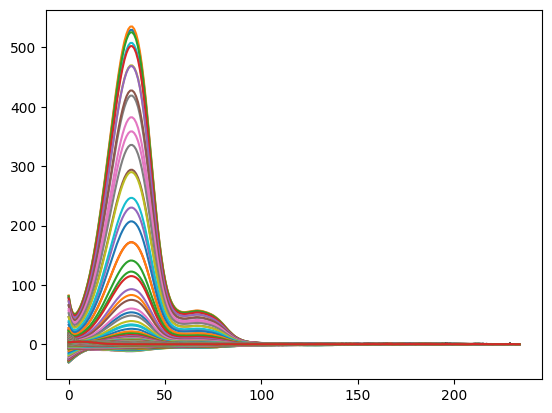

In [73]:
plt.plot(camp.chroms[0].dataset.data)

In [78]:
camp.chroms[0].dataset.data

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'bad_data',
 'dataset',
 'experiment',
 'insert_peak',
 'parafac_models',
 'peaks',
 'warnings']

In [36]:
# where to find in environment
print(f"Chroms attribute:\n{camp.chroms}\n")
print(f"User input for the chrom:\n{camp.chroms[0].experiment}\n")  # hplc_input is labelled "experiment" in the backend
print(f"Found peaks:\n{camp.chroms[0].peaks}\n")
print(f"Dataset:\n{camp.chroms[0].dataset}\n")
print(f"Bad Data:\n{camp.chroms[0].bad_data}")

Chroms attribute:
[<mocca.chromatogram.model.Chromatogram object at 0x28e1d1220>, <mocca.chromatogram.model.Chromatogram object at 0x28e1d1400>]

User input for the chrom:
HplcInput(path='/Users/bensonlee/dev/mocca/notebooks/tutorial_data/2022-01-26_19-48-52_ba_1.D', gradient=Gradient(/Users/bensonlee/dev/mocca/notebooks/tutorial_data/2022-01-26_19-43-27_gradient.D), compound=Compound(key='benzaldehyde', conc=1, is_solvent=False, is_istd=False), istd=None, processed=True, custom_data=None)

Found peaks:
[ProcessedPeak(left=1360, right=1399, maximum=1374, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=1, saturation=False, pure=True, integral=9543.834340739599, istd=[], compound_id='benzaldehyde_impurity_1', concentration=None, is_compound=False), ProcessedPeak(left=1437, right=1521, maximum=1471, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=2, saturation=False, pure=True, integral=260967.44102513973, istd=[], compound_id='benzaldehyde', concen

### Peak database

In this attribute, all processed peaks of all chromatograms in the campaign are stored. This database is used to create the qualitative and the quantitative component databases.

In [37]:
print(f"Database object:\n{camp.peak_db}\n")

print("Database entries (peaks):")
for peak in camp.peak_db:
    print(peak)

Database object:

Database entries (peaks):
ProcessedPeak(left=1437, right=1521, maximum=1471, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=2, saturation=False, pure=True, integral=260967.44102513973, istd=[], compound_id='benzaldehyde', concentration=1, is_compound=True)
ProcessedPeak(left=1360, right=1399, maximum=1374, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=1, saturation=False, pure=True, integral=9543.834340739599, istd=[], compound_id='benzaldehyde_impurity_1', concentration=None, is_compound=False)
ProcessedPeak(left=1448, right=1524, maximum=1472, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=1, saturation=False, pure=True, integral=140531.50647052407, istd=[], compound_id='benzaldehyde', concentration=0.5220528115582023, is_compound=False)


### Qualitative component database

In this database, the components (created from the signals of the same compound over multiple chromatograms) contain the information needed for peak assignment.

In [38]:
print(f"Database object:\n{camp.quali_comp_db}\n")

print("Database entries (qualitative components):")
for comp in camp.quali_comp_db:
    print(comp)

Database object:

Database entries (qualitative components):
QualiComponent(compound_id='benzaldehyde', left=1442, right=1522, maximum=1472, offset=0, spectrum=<class 'list'>, spectrum_max=[32, 67], created_from=[ProcessedPeak(left=1437, right=1521, maximum=1471, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=2, saturation=False, pure=True, integral=260967.44102513973, istd=[], compound_id='benzaldehyde', concentration=1, is_compound=True)])
QualiComponent(compound_id='benzaldehyde_impurity_1', left=1360, right=1399, maximum=1374, offset=0, spectrum=<class 'list'>, spectrum_max=[14, 36, 59, 57, 55, 61, 46, 66, 48, 44, 53, 40, 51], created_from=[ProcessedPeak(left=1360, right=1399, maximum=1374, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=1, saturation=False, pure=True, integral=9543.834340739599, istd=[], compound_id='benzaldehyde_impurity_1', concentration=None, is_compound=False)])


### Quantitative component database

In this database, the components (created from the signals of the same compound over multiple chromatograms) contain the information needed for peak quantification.

In [39]:
print(f"Database object:\n{camp.quant_comp_db}\n")

print("Database entries (quantitative components):")
for comp in camp.quant_comp_db:
    print(comp)

Database object:

Database entries (quantitative components):
QuantComponent(compound_id='benzaldehyde', integrate_wl_idx=32, calib_factors={'absolute': 8241.430639721371}, calib_data={'absolute': [(1, 8241.430639721371)]}, calib_scores={'absolute': nan}, created_from=[ProcessedPeak(left=1437, right=1521, maximum=1471, offset=0, dataset=<class 'mocca.dad_data.models.CompoundData'>, idx=2, saturation=False, pure=True, integral=260967.44102513973, istd=[], compound_id='benzaldehyde', concentration=1, is_compound=True)])
